# Modelo

## 01. Importar librerías

In [1]:
!pip install scikit-learn tensorflow pathlib


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# -- Manejo de rutas ---
import pathlib

# --- Manejo de datos ---
import pandas as pd
import numpy as np
import ast

# --- Machine Learning / Red neuronal ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# --- Visualización (opcional, pero útil) ---
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization
from tensorflow.keras import optimizers, callbacks

import os, time, json, numpy as np, tensorflow as tf, pandas as pd
from tensorflow.keras import layers, models, optimizers, callbacks, losses, metrics

from pathlib import Path

from sklearn.metrics import mean_squared_error
import tensorflow as tf



In [3]:
DATA_DIR = pathlib.Path().absolute().parent / "resultados_v6"

In [4]:
# Listar algunos archivos en el directorio de datos para verificar que existe
list(DATA_DIR.glob("*"))[:5]

[WindowsPath('c:/Users/Profesor/OneDrive - Universidad de los andes/Investigacion/Investigacion/resultados_v6/W128_mu16_w16_eta2_a1_b10_binned_pow2.csv'),
 WindowsPath('c:/Users/Profesor/OneDrive - Universidad de los andes/Investigacion/Investigacion/resultados_v6/W128_mu16_w16_eta2_a1_b15_binned_pow2.csv'),
 WindowsPath('c:/Users/Profesor/OneDrive - Universidad de los andes/Investigacion/Investigacion/resultados_v6/W128_mu16_w16_eta2_a1_b20_binned_pow2.csv'),
 WindowsPath('c:/Users/Profesor/OneDrive - Universidad de los andes/Investigacion/Investigacion/resultados_v6/W128_mu16_w16_eta2_a1_b25_binned_pow2.csv'),
 WindowsPath('c:/Users/Profesor/OneDrive - Universidad de los andes/Investigacion/Investigacion/resultados_v6/W128_mu16_w16_eta2_a1_b3_binned_pow2.csv')]

In [5]:
def parse_list(x):
    """Convierte columnas que vienen como strings '[1,2,3]' a listas reales"""
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return None
    return x

In [6]:
frames = []
files = []

if DATA_DIR.exists() and DATA_DIR.is_dir():
    for p in DATA_DIR.glob("*.csv"):
        try:
            df = pd.read_csv(p)

            # Parsear columnas que contienen listas en texto
            for col in ("edges_last", "NE_bin_avg", "C_bin_rate", "NE_pref_avg", "C_pref_rate"):
                if col in df.columns:
                    df[col] = df[col].apply(parse_list)

            df["__source__"] = p.name
            frames.append(df)
            files.append(p)
        except Exception as e:
            print(f"⚠️ No se pudo leer {p}: {e}")

if not frames:
    raise RuntimeError(f"❌ No se encontraron CSV en {DATA_DIR}")

df_all = pd.concat(frames, ignore_index=True)
print(f"✅ Archivos cargados: {len(files)} — Filas totales: {len(df_all)}")
print("Ejemplo de archivos:", [p.name for p in files[:5]])

✅ Archivos cargados: 1062 — Filas totales: 1062
Ejemplo de archivos: ['W128_mu16_w16_eta2_a1_b10_binned_pow2.csv', 'W128_mu16_w16_eta2_a1_b15_binned_pow2.csv', 'W128_mu16_w16_eta2_a1_b20_binned_pow2.csv', 'W128_mu16_w16_eta2_a1_b25_binned_pow2.csv', 'W128_mu16_w16_eta2_a1_b3_binned_pow2.csv']


In [7]:
# Revisar cuántos valores distintos de m_bins hay en el dataset
valores_unicos = df_all["m_bins"].unique()
print("Valores únicos de m_bins:", valores_unicos)
print("Cantidad de valores distintos:", len(valores_unicos))

# Conteo de frecuencia
conteo = df_all["m_bins"].value_counts().sort_index()
print("\nFrecuencia de cada m_bins:")
print(conteo)


Valores únicos de m_bins: [ 8  0 32 16]
Cantidad de valores distintos: 4

Frecuencia de cada m_bins:
m_bins
0     733
8     179
16     76
32     74
Name: count, dtype: int64


In [8]:
df_all.head()

,W,mu,w,eta,alpha,beta,N,N_valid,excluded_seeds,exception_failures,...,edges_last,NE_bin_avg,C_bin_rate,NE_pref_avg,C_pref_rate,excluded_rate,exception_rate,valid_failure_rate,seed,__source__
0,128,16,16,2,0.001,0.10,100,1,99,0,...,"[62711, 85727, 108743, 131759, 154775, 177791,...","[0.0, 33.0, 802.0, 5996.0, 20001.0, 24540.0, 8...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 33.0, 835.0, 6831.0, 26832.0, 51372.0, 5...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.99,0.0,0.0,42,W128_mu16_w16_eta2_a1_b10_binned_pow2.csv
1,128,16,16,2,0.001,0.15,100,0,100,0,...,[],[],[],[],[],1.00,0.0,0.0,42,W128_mu16_w16_eta2_a1_b15_binned_pow2.csv
2,128,16,16,2,0.001,0.20,100,0,100,0,...,[],[],[],[],[],1.00,0.0,0.0,42,W128_mu16_w16_eta2_a1_b20_binned_pow2.csv
3,128,16,16,2,0.001,0.25,100,0,100,0,...,[],[],[],[],[],1.00,0.0,0.0,42,W128_mu16_w16_eta2_a1_b25_binned_pow2.csv
4,128,16,16,2,0.001,0.03,100,30,70,0,...,"[19025, 53412, 87799, 122186, 156572, 190958, ...","[0.0, 44.43333333333333, 438.7, 3373.833333333...","[0.5333, 0.2667, 0.1333, 0.0667, 0.0, 0.0, 0.0...","[0.0, 44.43333333333333, 483.1333333333333, 38...","[0.5333, 0.8, 0.9333, 1.0, 1.0, 1.0, 1.0, 1.0]",0.70,0.0,0.0,42,W128_mu16_w16_eta2_a1_b3_binned_pow2.csv


In [9]:
def _as_list(x):
    if isinstance(x, list): return x
    if isinstance(x, str) and x.strip().startswith('[') and x.strip().endswith(']'):
        try: return ast.literal_eval(x)
        except Exception: return None
    return None

def build_prefix_dataset(df_all: pd.DataFrame,
                         jeffreys: bool = True,
                         globalize: bool = True) -> pd.DataFrame:
    rows = []
    for _, r in df_all.iterrows():
        edges = _as_list(r.get("edges_last"))
        cbin  = _as_list(r.get("C_bin_rate"))
        cpref = _as_list(r.get("C_pref_rate"))
        if not (isinstance(edges, list) and len(edges) >= 2):
            continue
        m = len(edges) - 1
        if not isinstance(cpref, list) and isinstance(cbin, list) and len(cbin)==m:
            cpref = list(np.clip(np.cumsum(cbin), 0, 1))

        if not (isinstance(cpref, list) and len(cpref)==m):
            continue

        # Entradas del Alg. 7 (P se resume con α,β)
        W=float(r["W"]); w=float(r["w"]); mu=float(r["mu"]); eta=float(r["eta"])
        alpha=float(r["alpha"]); beta=float(r["beta"])
        Bmin=float(r.get("Bmin_avg", edges[0]))

        # Tamaños de muestra
        N=float(r.get("N", 0) or 0)
        N_valid = r.get("N_valid")
        if N_valid is None or (isinstance(N_valid, float) and np.isnan(N_valid)):
            N_valid = N - float(r.get("excluded_seeds",0) or 0) - float(r.get("errors",0) or 0)
        N_valid=float(max(0.0, N_valid))

        for k in range(m):
            B2=float(edges[k+1])
            base = float(cpref[k])                    # prob. sobre válidas hasta B2
            if jeffreys:                              # suavizado Jeffreys
                s = base * N_valid
                base = (s + 0.5) / (N_valid + 1.0) if N_valid>0 else base
            if globalize and N>0:                     # escala GLOBAL (cuenta excluidas/excepciones)
                base *= (N_valid / N)

            rows.append({
                "W":W,"w":w,"mu":mu,"eta":eta,"alpha":alpha,"beta":beta,
                "Bmin":Bmin,"B2":B2,
                "y_prefix": float(base),
                "group_id": f"W{int(W)}_w{int(w)}_mu{int(mu)}_eta{int(eta)}_a{alpha}_b{beta}",
                "k": k,
            })
    return pd.DataFrame(rows)

# Ejemplo de construcción:
df_prefix = build_prefix_dataset(df_all, jeffreys=True, globalize=True)

In [10]:
df_prefix.head(34)

,W,w,mu,eta,alpha,beta,Bmin,B2,y_prefix,group_id,k
0,128.0,16.0,16.0,2.0,0.001,0.10,62711.0,85727.0,0.002500,W128_w16_mu16_eta2_a0.001_b0.1,0
1,128.0,16.0,16.0,2.0,0.001,0.10,62711.0,108743.0,0.002500,W128_w16_mu16_eta2_a0.001_b0.1,1
2,128.0,16.0,16.0,2.0,0.001,0.10,62711.0,131759.0,0.007500,W128_w16_mu16_eta2_a0.001_b0.1,2
3,128.0,16.0,16.0,2.0,0.001,0.10,62711.0,154775.0,0.007500,W128_w16_mu16_eta2_a0.001_b0.1,3
4,128.0,16.0,16.0,2.0,0.001,0.10,62711.0,177791.0,0.007500,W128_w16_mu16_eta2_a0.001_b0.1,4
5,128.0,16.0,16.0,2.0,0.001,0.10,62711.0,200807.0,0.007500,W128_w16_mu16_eta2_a0.001_b0.1,5
6,128.0,16.0,16.0,2.0,0.001,0.10,62711.0,223822.0,0.007500,W128_w16_mu16_eta2_a0.001_b0.1,6
7,128.0,16.0,16.0,2.0,0.001,0.10,62711.0,246837.0,0.007500,W128_w16_mu16_eta2_a0.001_b0.1,7
8,128.0,16.0,16.0,2.0,0.001,0.03,20252.0,53412.0,0.159668,W128_w16_mu16_eta2_a0.001_b0.03,0
9,128.0,16.0,16.0,2.0,0.001,0.03,20252.0,87799.0,0.237097,W128_w16_mu16_eta2_a0.001_b0.03,1


In [11]:
X_cols = ["W","w","mu","eta","alpha","beta","Bmin","B2"]
y_col  = "y_prefix"; g_col = "group_id"

X = df_prefix[X_cols].to_numpy(dtype="float32")
y = df_prefix[y_col].to_numpy(dtype="float32")
groups = df_prefix[g_col].to_numpy()

# split 80/20 por grupo
rng = np.random.default_rng(42)
uniq = np.unique(groups)
test_groups = set(rng.choice(uniq, size=max(1,int(0.2*len(uniq))), replace=False))
mask_te = np.array([g in test_groups for g in groups])
Xtr,Xte = X[~mask_te], X[mask_te]
ytr,yte = y[~mask_te], y[mask_te]
gtr,gte = groups[~mask_te], groups[mask_te]

# modelo
tf.random.set_seed(42)
norm = Normalization(); norm.adapt(Xtr)
model = Sequential([
    norm,
    Dense(32, activation="relu"),
    Dropout(0.1),
    Dense(16, activation="relu"),
    Dropout(0.1),
    Dense(8, activation="relu"),
    Dropout(0.1),
    Dense(4, activation="relu"),
    Dropout(0.1),
    Dense(2, activation="relu"),
    Dropout(0.1),
    Dense(1, activation="sigmoid")  # prob en (0,1)
])
model.compile(optimizer=optimizers.Adam(1e-3),
              loss="binary_crossentropy",             # funciona con etiquetas suaves
              metrics=[tf.keras.metrics.MeanSquaredError(name="brier_soft")])

es  = callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-5)

hist = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                 epochs=600, batch_size=1024,
                 callbacks=[es, rlr], verbose=1)


Epoch 1/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - brier_soft: 0.1382 - loss: 0.6561 - val_brier_soft: 0.1535 - val_loss: 0.6587 - learning_rate: 0.0010
Epoch 2/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - brier_soft: 0.1313 - loss: 0.6420 - val_brier_soft: 0.1457 - val_loss: 0.6430 - learning_rate: 0.0010
Epoch 3/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - brier_soft: 0.1245 - loss: 0.6281 - val_brier_soft: 0.1371 - val_loss: 0.6256 - learning_rate: 0.0010
Epoch 4/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - brier_soft: 0.1166 - loss: 0.6116 - val_brier_soft: 0.1277 - val_loss: 0.6062 - learning_rate: 0.0010
Epoch 5/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - brier_soft: 0.1088 - loss: 0.5952 - val_brier_soft: 0.1168 - val_loss: 0.5836 - learning_rate: 0.0010
Epoch 6/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - brier_soft: 0.1016 - loss: 0.5798 - val_brier_soft: 0.1053 - val_loss: 0.5594 - learning_rate: 0.0010
Epoch 7/600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - brier_soft: 0.0924 - los

In [12]:
# listar configuraciones disponibles
gids = df_prefix["group_id"].unique()
print(f"{len(gids)} configuraciones. Ejemplos:", gids[:5])

# elige una
GID = gids[0]   # o reemplaza por el que quieras


329 configuraciones. Ejemplos: ['W128_w16_mu16_eta2_a0.001_b0.1' 'W128_w16_mu16_eta2_a0.001_b0.03'
 'W128_w16_mu16_eta2_a0.001_b0.05' 'W128_w16_mu16_eta4_a0.001_b0.03'
 'W128_w16_mu16_eta4_a0.001_b0.05']


In [13]:
# asegúrate de tener X_cols definido como en el entrenamiento
rows = df_prefix.loc[df_prefix["group_id"]==GID].sort_values("B2")
X_cfg = rows[X_cols].to_numpy(dtype="float32")

# predicción P(score ∈ [Bmin, B2)) para cada corte B2 de esa config
p_hat_prefix = model.predict(X_cfg, verbose=0).ravel()

# probabilidad del bin puro [edge_k, edge_{k+1}) = diferencia de prefijos
p_hat_bin = np.diff(np.concatenate(([0.0], p_hat_prefix)))

print("GID:", GID)
print("B2 cortes:", rows["B2"].tolist())
print("P_hat prefix:", p_hat_prefix.tolist())
print("P_hat por bin:", p_hat_bin.tolist())
# el último prefijo es la probabilidad global estimada para esa configuración
print("P_global_hat:", float(p_hat_prefix[-1]))

GID: W128_w16_mu16_eta2_a0.001_b0.1
B2 cortes: [85727.0, 108743.0, 131759.0, 154775.0, 177791.0, 200807.0, 223822.0, 246837.0]
P_hat prefix: [0.04523961618542671, 0.04544207081198692, 0.04564538598060608, 0.045849572867155075, 0.04605460539460182, 0.04626054689288139, 0.046467337757349014, 0.04674098640680313]
P_hat por bin: [0.04523961618542671, 0.00020245462656021118, 0.00020331516861915588, 0.00020418688654899597, 0.00020503252744674683, 0.00020594149827957153, 0.00020679086446762085, 0.0002736486494541168]
P_global_hat: 0.04674098640680313


,brier_soft,loss,val_brier_soft,val_loss,learning_rate
170,0.023603,0.376295,0.009238,0.306371,0.000063
171,0.023858,0.376915,0.009234,0.306359,0.000031
172,0.023113,0.374518,0.009231,0.306346,0.000031
173,0.024910,0.379136,0.009228,0.306331,0.000031
174,0.024072,0.377003,0.009227,0.306323,0.000031


Mejor época (val_loss): 159  |  val_loss=0.306320


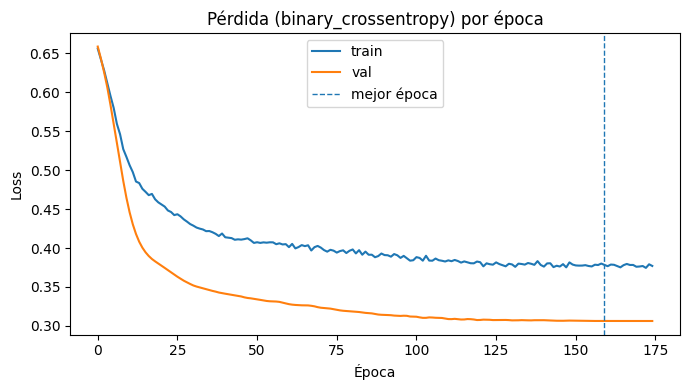

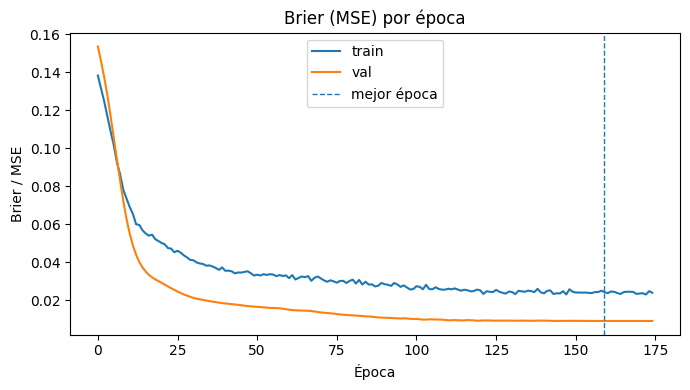

In [14]:
# 1) Pasar el History a DataFrame
hist_df = pd.DataFrame(hist.history)
display(hist_df.tail(5))  # últimas 5 épocas

# 2) Mejor época según val_loss
best_ep = int(hist_df["val_loss"].idxmin())
best_val = float(hist_df.loc[best_ep, "val_loss"])
print(f"Mejor época (val_loss): {best_ep}  |  val_loss={best_val:.6f}")

# 3) Curva de pérdida
plt.figure(figsize=(7,4))
plt.plot(hist_df["loss"], label="train")
plt.plot(hist_df["val_loss"], label="val")
plt.axvline(best_ep, ls="--", lw=1, label="mejor época")
plt.title("Pérdida (binary_crossentropy) por época")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.savefig("loss_curve.png", dpi=140); plt.show()

# 4) Curva del métrico (Brier soft = MSE)
if "brier_soft" in hist_df.columns:
    plt.figure(figsize=(7,4))
    plt.plot(hist_df["brier_soft"], label="train")
    if "val_brier_soft" in hist_df.columns:
        plt.plot(hist_df["val_brier_soft"], label="val")
    plt.axvline(best_ep, ls="--", lw=1, label="mejor época")
    plt.title("Brier (MSE) por época")
    plt.xlabel("Época"); plt.ylabel("Brier / MSE"); plt.legend()
    plt.tight_layout(); plt.savefig("brier_curve.png", dpi=140); plt.show()
else:
    print("⚠️ No encontré 'brier_soft' en hist.history. Columnas:", hist_df.columns.tolist())


In [15]:
def brier_soft(y, p):
    return np.mean((y - p)**2)

def logloss_soft(y, p):
    p = np.clip(p, 1e-6, 1-1e-6)
    return -np.mean(y*np.log(p) + (1-y)*np.log(1-p))

p_tr = model.predict(Xtr, verbose=0).ravel()
p_te = model.predict(Xte, verbose=0).ravel()

print("=== Métricas por-bin ===")
print("Train Brier:", round(brier_soft(ytr, p_tr), 6))
print("Test  Brier:", round(brier_soft(yte, p_te), 6))
print("Train LogLoss:", round(logloss_soft(ytr, p_tr), 6))
print("Test  LogLoss:", round(logloss_soft(yte, p_te), 6))

=== Métricas por-bin ===
Train Brier: 0.010949
Test  Brier: 0.009215
Train LogLoss: 0.344359
Test  LogLoss: 0.30632


In [16]:
df_eval = df_prefix.copy()
df_eval["y_hat"] = model.predict(df_prefix[X_cols].to_numpy(dtype="float32"), verbose=0).ravel()

# Tomar el último B2 (Bmax) de cada configuración
cfg_eval = (df_eval.sort_values(["group_id","B2"])
                   .groupby("group_id", as_index=False)
                   .tail(1)[["group_id","y_prefix","y_hat"]]
                   .rename(columns={"y_prefix":"p_true","y_hat":"p_pred"}))

err = cfg_eval["p_pred"] - cfg_eval["p_true"]
mae  = np.mean(np.abs(err))
rmse = np.sqrt(np.mean(err**2))
r2   = 1 - np.var(err)/np.var(cfg_eval["p_true"])
print("\n=== Métricas por configuración ===")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")


=== Métricas por configuración ===
MAE  = 0.0592
RMSE = 0.0853
R²   = 0.7223


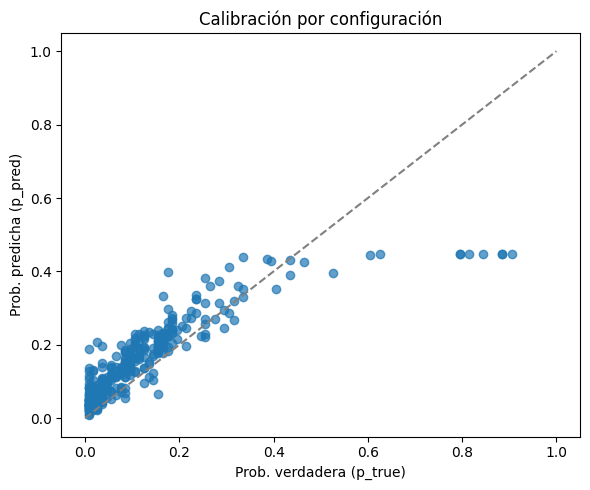

In [17]:
plt.figure(figsize=(6,5))
plt.scatter(cfg_eval["p_true"], cfg_eval["p_pred"], alpha=0.7)
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("Prob. verdadera (p_true)")
plt.ylabel("Prob. predicha (p_pred)")
plt.title("Calibración por configuración")
plt.tight_layout()
plt.show()


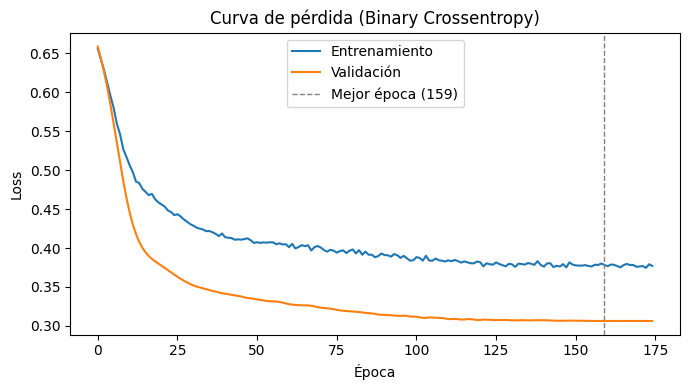

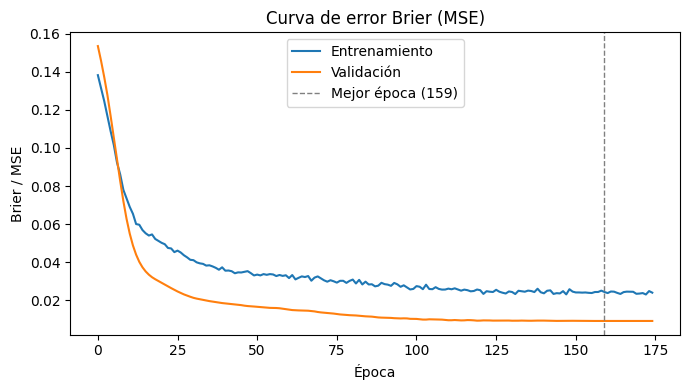

In [18]:
hist_df = pd.DataFrame(hist.history)
best_ep = int(hist_df["val_loss"].idxmin())

plt.figure(figsize=(7,4))
plt.plot(hist_df["loss"], label="Entrenamiento")
plt.plot(hist_df["val_loss"], label="Validación")
plt.axvline(best_ep, color="gray", linestyle="--", lw=1, label=f"Mejor época ({best_ep})")
plt.title("Curva de pérdida (Binary Crossentropy)")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve_summary.png", dpi=140)
plt.show()

if "brier_soft" in hist_df.columns:
    plt.figure(figsize=(7,4))
    plt.plot(hist_df["brier_soft"], label="Entrenamiento")
    plt.plot(hist_df["val_brier_soft"], label="Validación")
    plt.axvline(best_ep, color="gray", linestyle="--", lw=1, label=f"Mejor época ({best_ep})")
    plt.title("Curva de error Brier (MSE)")
    plt.xlabel("Época")
    plt.ylabel("Brier / MSE")
    plt.legend()
    plt.tight_layout()
    plt.savefig("brier_curve_summary.png", dpi=140)
    plt.show()


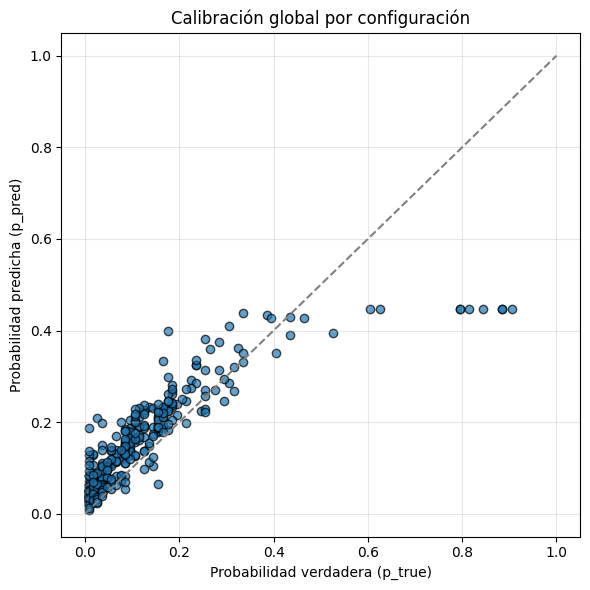

In [19]:
# Dataset agregado (usa df_eval o cfg_eval según tu código)
df_eval = df_prefix.copy()
df_eval["y_hat"] = model.predict(df_prefix[X_cols].to_numpy(dtype="float32"), verbose=0).ravel()

cfg_eval = (df_eval.sort_values(["group_id","B2"])
                   .groupby("group_id", as_index=False)
                   .tail(1)[["group_id","y_prefix","y_hat"]]
                   .rename(columns={"y_prefix":"p_true","y_hat":"p_pred"}))

plt.figure(figsize=(6,6))
plt.scatter(cfg_eval["p_true"], cfg_eval["p_pred"], alpha=0.7, edgecolor="k")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("Probabilidad verdadera (p_true)")
plt.ylabel("Probabilidad predicha (p_pred)")
plt.title("Calibración global por configuración")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("calibracion_global.png", dpi=140)
plt.show()


In [20]:
# ✅ Guarda el modelo completo (recomendado en TF ≥2.12)
model.save("modelo.keras")   # crea archivo compacto (~2–3 MB)

In [21]:
# ======================= Ranking de modelos + historiales =======================

# ---------- Constructor de modelos parametrizable ----------
def make_keras_model(input_dim,
                     hidden_layers=(64,64),
                     dropout=0.2,
                     use_batchnorm=False,
                     lr=1e-3,
                     loss_name="mse",   # "mse" | "huber" | "bce" | "bce_ls"
                     huber_delta=0.1,
                     label_smoothing=0.0):
    """
    MLP para probabilidad calibrada con Normalization al inicio y sigmoide al final.
    """
    inp = layers.Input(shape=(input_dim,), dtype="float32")
    norm = layers.Normalization()
    x = norm(inp)
    for h in hidden_layers:
        x = layers.Dense(h, activation="relu")(x)
        if use_batchnorm:
            x = layers.BatchNormalization()(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    # Pérdida
    if loss_name == "mse":
        loss_fn = losses.MeanSquaredError()
    elif loss_name == "huber":
        loss_fn = losses.Huber(delta=float(huber_delta))
    elif loss_name == "bce":
        loss_fn = losses.BinaryCrossentropy()
    elif loss_name == "bce_ls":
        loss_fn = losses.BinaryCrossentropy(label_smoothing=float(label_smoothing))
    else:
        raise ValueError(f"loss desconocida: {loss_name}")

    model = models.Model(inp, out)
    model.compile(
        optimizer=optimizers.Adam(lr),
        loss=loss_fn,
        metrics=[
            metrics.MeanSquaredError(name="brier"),      # Brier = MSE sobre probas
            metrics.BinaryCrossentropy(name="nll")       # NLL como referencia
        ]
    )
    return model, norm


# ---------- Runner + ranking (con historiales y fix de forma y∈R^{n×1}) ----------
def run_and_rank(
    Xtr, ytr, Xte, yte,
    arch_space,                     # lista de dicts con configs de make_keras_model
    out_dir="exp_ranked",
    max_epochs=300, batch_size=1024,
    seed=42, verbose=True,
    save_history_json=True
):
    """
    Entrena un experimento por configuración en arch_space:
      - Guarda best_<tag>.keras (mejor checkpoint por val_loss)
      - Guarda <tag>_history.csv (+ .json opcional) con curvas por época
      - Crea ranking.csv ordenado por val_min, test_brier, test_nll
    Devuelve: (df_ranking, best_model, best_path)
    """
    os.makedirs(out_dir, exist_ok=True)
    np.random.seed(seed); tf.random.set_seed(seed)

    # ---- Asegurar forma 2D en etiquetas: (n,1) ----
    ytr2 = np.asarray(ytr, dtype="float32")
    yte2 = np.asarray(yte, dtype="float32")
    if ytr2.ndim == 1: ytr2 = ytr2[:, None]
    if yte2.ndim == 1: yte2 = yte2[:, None]

    rows = []

    for i, cfg in enumerate(arch_space, 1):
        tag = cfg.get("tag") or (
            f"h{cfg.get('hidden_layers')}_do{cfg.get('dropout',0)}"
            f"_bn{int(cfg.get('use_batchnorm',False))}_{cfg.get('loss','mse')}"
            f"{('_d'+str(cfg.get('huber_delta'))) if cfg.get('loss')=='huber' else ''}"
            f"{('_ls'+str(cfg.get('label_smoothing'))) if cfg.get('loss')=='bce_ls' else ''}"
        )
        if verbose:
            print(f"\n=== [{i}/{len(arch_space)}] {tag} ===")

        # Construir modelo
        model, norm = make_keras_model(
            input_dim=Xtr.shape[1],
            hidden_layers=cfg.get("hidden_layers", (64,64)),
            dropout=cfg.get("dropout", 0.2),
            use_batchnorm=cfg.get("use_batchnorm", False),
            lr=cfg.get("lr", 1e-3),
            loss_name=cfg.get("loss", "mse"),
            huber_delta=cfg.get("huber_delta", 0.1),
            label_smoothing=cfg.get("label_smoothing", 0.0)
        )
        # Adaptar normalizador
        norm.adapt(Xtr)

        ckpt_path = os.path.join(out_dir, f"best_{tag}.keras")
        es  = callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
        rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-5)
        ck  = callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True)

        # Entrenamiento
        t0 = time.time()
        hist = model.fit(
            Xtr, ytr2,
            validation_data=(Xte, yte2),
            epochs=max_epochs, batch_size=batch_size,
            callbacks=[es, rlr, ck],
            verbose=0
        )
        dt = time.time() - t0

        # Guardar historial por época
        hist_df = pd.DataFrame(hist.history)
        hist_df.insert(0, "epoch", np.arange(1, len(hist_df)+1))
        hist_csv = os.path.join(out_dir, f"{tag}_history.csv")
        hist_df.to_csv(hist_csv, index=False)
        if save_history_json:
            with open(os.path.join(out_dir, f"{tag}_history.json"), "w") as f:
                json.dump(hist.history, f, indent=2)

        # Cargar mejor checkpoint
        try:
            best = tf.keras.models.load_model(ckpt_path)
        except Exception:
            best = model

        # Evaluación final (usa yte2 en forma 2D)
        te_loss, te_brier, te_nll = best.evaluate(Xte, yte2, verbose=0)
        val_min = float(np.min(hist.history["val_loss"]))

        row = {
            "tag": tag,
            **cfg,
            "epochs": len(hist.history["loss"]),
            "train_time_s": round(dt, 2),
            "val_min": float(val_min),
            "test_loss": float(te_loss),
            "test_brier": float(te_brier),
            "test_nll": float(te_nll),
            "model_path": ckpt_path,
            "history_csv": hist_csv
        }
        rows.append(row)

        if verbose:
            print(f"val_min={val_min:.4f}  test_brier={te_brier:.4f}  test_nll={te_nll:.4f}")
            print(f"→ checkpoint: {ckpt_path}")
            print(f"→ history:    {hist_csv}")

    # Ranking y carga del mejor
    df = pd.DataFrame(rows)
    df_sorted = df.sort_values(["val_min", "test_brier", "test_nll"],
                               ascending=[True, True, True]).reset_index(drop=True)
    df_sorted.to_csv(os.path.join(out_dir, "ranking.csv"), index=False)

    best_path = df_sorted.iloc[0]["model_path"]
    best_model = tf.keras.models.load_model(best_path)

    if verbose:
        print("\n=== TOP 5 ===")
        print(df_sorted.head(5)[["tag","val_min","test_brier","test_nll","model_path","history_csv"]])
        print(f"\nMejor modelo: {best_path}")

    return df_sorted, best_model, best_path


In [22]:
# ======================= ARCH_SPACE AMPLIADO (30 variantes) =======================
arch_space = [
    # --- Shallow (rápidos/estables) ---
    {"tag":"shallow32_mse",        "hidden_layers":(32,32),            "dropout":0.1, "use_batchnorm":False, "lr":1e-3,  "loss":"mse"},
    {"tag":"shallow64_mse",        "hidden_layers":(64,64),            "dropout":0.2, "use_batchnorm":False, "lr":1e-3,  "loss":"mse"},
    {"tag":"shallow64_bn_mse",     "hidden_layers":(64,64),            "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"shallow128_64_mse",    "hidden_layers":(128,64),           "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"shallow64_huber005",   "hidden_layers":(64,64),            "dropout":0.2, "use_batchnorm":False, "lr":1e-3,  "loss":"huber", "huber_delta":0.05},
    {"tag":"shallow64_huber010",   "hidden_layers":(64,64),            "dropout":0.2, "use_batchnorm":False, "lr":1e-3,  "loss":"huber", "huber_delta":0.10},
    {"tag":"shallow64_huber015",   "hidden_layers":(64,64),            "dropout":0.2, "use_batchnorm":False, "lr":1e-3,  "loss":"huber", "huber_delta":0.15},
    {"tag":"shallow32_bce_ls03",   "hidden_layers":(32,32),            "dropout":0.2, "use_batchnorm":False, "lr":1e-3,  "loss":"bce_ls","label_smoothing":0.03},

    # --- Mid (un poco más de capacidad) ---
    {"tag":"mid_128_128_mse",      "hidden_layers":(128,128),          "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"mid_128_128_lr5e4",    "hidden_layers":(128,128),          "dropout":0.2, "use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},
    {"tag":"mid_128_64_32_mse",    "hidden_layers":(128,64,32),        "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"mid_128_64_32_h010",   "hidden_layers":(128,64,32),        "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"huber","huber_delta":0.10},
    {"tag":"mid_96_64_32_mse",     "hidden_layers":(96,64,32),         "dropout":0.15,"use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"mid_96_64_32_lr5e4",   "hidden_layers":(96,64,32),         "dropout":0.15,"use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},
    {"tag":"mid_64_64_64_mse",     "hidden_layers":(64,64,64),         "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"mid_64_64_64_h005",    "hidden_layers":(64,64,64),         "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"huber","huber_delta":0.05},

    # --- Deep (si notas underfit) ---
    {"tag":"deep_256_128_64_mse",  "hidden_layers":(256,128,64),       "dropout":0.2, "use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},
    {"tag":"deep_256_128_64_h010", "hidden_layers":(256,128,64),       "dropout":0.2, "use_batchnorm":True,  "lr":5e-4,  "loss":"huber","huber_delta":0.10},
    {"tag":"deep_128x4_mse",       "hidden_layers":(128,128,128,128),  "dropout":0.15,"use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},
    {"tag":"deep_128x4_h005",      "hidden_layers":(128,128,128,128),  "dropout":0.15,"use_batchnorm":True,  "lr":5e-4,  "loss":"huber","huber_delta":0.05},
    {"tag":"deep_96x5_mse",        "hidden_layers":(96,96,96,96,96),   "dropout":0.1, "use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},

    # --- Wide & Shallow (si hay no linealidades suaves) ---
    {"tag":"wide_256_128_mse",     "hidden_layers":(256,128),          "dropout":0.2, "use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},
    {"tag":"wide_256_128_h015",    "hidden_layers":(256,128),          "dropout":0.2, "use_batchnorm":True,  "lr":5e-4,  "loss":"huber","huber_delta":0.15},
    {"tag":"wide_320_160_mse",     "hidden_layers":(320,160),          "dropout":0.25,"use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},
    {"tag":"wide_192_96_bce_ls05", "hidden_layers":(192,96),           "dropout":0.2, "use_batchnorm":True,  "lr":7e-4,  "loss":"bce_ls","label_smoothing":0.05},

    # --- Regularización fuerte (si hay overfit) ---
    {"tag":"reg_64_32_16_mse",     "hidden_layers":(64,32,16),         "dropout":0.3, "use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"reg_64_32_16_h010",    "hidden_layers":(64,32,16),         "dropout":0.3, "use_batchnorm":True,  "lr":1e-3,  "loss":"huber","huber_delta":0.10},
    {"tag":"reg_48_24_12_mse",     "hidden_layers":(48,24,12),         "dropout":0.35,"use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"reg_32_16_8_bce_ls03", "hidden_layers":(32,16,8),          "dropout":0.3, "use_batchnorm":False, "lr":1e-3,  "loss":"bce_ls","label_smoothing":0.03},

    # --- “Tiny” (baseline/ablation) ---
    {"tag":"tiny_16_16_mse",       "hidden_layers":(16,16),            "dropout":0.1, "use_batchnorm":False, "lr":1e-3,  "loss":"mse"},
    {"tag":"tiny_16_8_mse",        "hidden_layers":(16,8),             "dropout":0.1, "use_batchnorm":False, "lr":1e-3,  "loss":"mse"},
]

In [23]:
# Asegúrate de tener Xtr, ytr, Xte, yte (float32); y* en [0,1]
df_rank, best_model, best_path = run_and_rank(
    Xtr, ytr, Xte, yte,
    arch_space=arch_space,
    out_dir="exp_ranked_models",
    max_epochs=300, batch_size=1024,
    seed=42, verbose=True
)


=== [1/31] shallow32_mse ===
val_min=0.0030  test_brier=0.0030  test_nll=0.3014
→ checkpoint: exp_ranked_models\best_shallow32_mse.keras
→ history:    exp_ranked_models\shallow32_mse_history.csv

=== [2/31] shallow64_mse ===
val_min=0.0028  test_brier=0.0028  test_nll=0.3166
→ checkpoint: exp_ranked_models\best_shallow64_mse.keras
→ history:    exp_ranked_models\shallow64_mse_history.csv

=== [3/31] shallow64_bn_mse ===
val_min=0.0022  test_brier=0.0022  test_nll=0.2975
→ checkpoint: exp_ranked_models\best_shallow64_bn_mse.keras
→ history:    exp_ranked_models\shallow64_bn_mse_history.csv

=== [4/31] shallow128_64_mse ===
val_min=0.0021  test_brier=0.0021  test_nll=0.3096
→ checkpoint: exp_ranked_models\best_shallow128_64_mse.keras
→ history:    exp_ranked_models\shallow128_64_mse_history.csv

=== [5/31] shallow64_huber005 ===
val_min=0.0012  test_brier=0.0042  test_nll=0.2992
→ checkpoint: exp_ranked_models\best_shallow64_huber005.keras
→ history:    exp_ranked_models\shallow64_huber

Tag detectado: mid_64_64_64_h005
Historial esperado: exp_ranked_models\mid_64_64_64_h005_history.csv


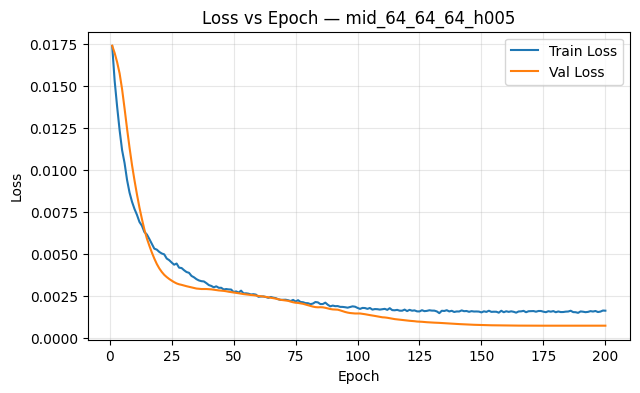

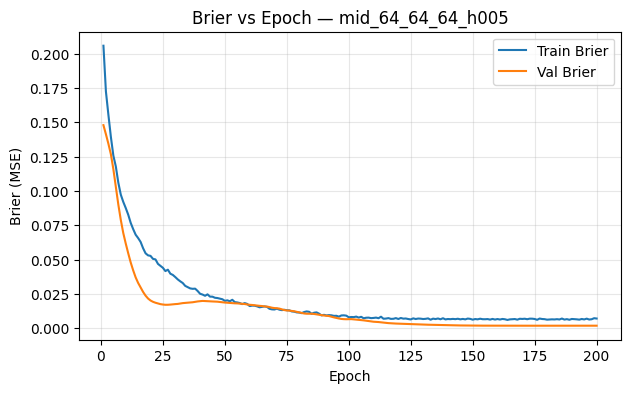

Predicciones test → min/mean/max: 0.010476 / 0.127904 / 0.999999
Brier_ext=0.0019  NLL_ext=0.2995


In [24]:
# --- 1) Cargar el mejor modelo desde best_path y (opcional) guardarlo con nombre final ---
best_path = Path(best_path)  # viene de run_and_rank
best_model = tf.keras.models.load_model(best_path)
best_model.save("modelo_prefijo_FINAL.keras")  # duplicado con nombre estable

# --- 2) Encontrar el CSV de historial a partir del nombre del checkpoint ---
# Formato del checkpoint: out_dir / f"best_{tag}.keras"
tag = best_path.stem.replace("best_", "")              # e.g., "shallow64_mse"
hist_csv = best_path.parent / f"{tag}_history.csv"     # e.g., exp_ranked_models/shallow64_mse_history.csv"

print("Tag detectado:", tag)
print("Historial esperado:", hist_csv)

# --- 3) Cargar historial y graficar ---
if hist_csv.exists():
    hist = pd.read_csv(hist_csv)

    # Loss
    plt.figure(figsize=(7,4))
    plt.plot(hist["epoch"], hist["loss"], label="Train Loss")
    plt.plot(hist["epoch"], hist["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"Loss vs Epoch — {tag}")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()

    # Brier (si está)
    if "brier" in hist.columns and "val_brier" in hist.columns:
        plt.figure(figsize=(7,4))
        plt.plot(hist["epoch"], hist["brier"], label="Train Brier")
        plt.plot(hist["epoch"], hist["val_brier"], label="Val Brier")
        plt.xlabel("Epoch"); plt.ylabel("Brier (MSE)")
        plt.title(f"Brier vs Epoch — {tag}")
        plt.legend(); plt.grid(True, alpha=0.3)
        plt.show()
else:
    print(f"⚠️ No se encontró el historial: {hist_csv}")

# --- 4) (Opcional) Métricas rápidas en test ---
p_te = best_model.predict(Xte, verbose=0).ravel()
p_te = np.clip(p_te, 1e-6, 1-1e-6)
y_true = np.asarray(yte).ravel().astype("float32")

from sklearn.metrics import mean_squared_error
brier = mean_squared_error(y_true, p_te)
import tensorflow as tf
nll = float(tf.keras.losses.BinaryCrossentropy()(y_true, p_te).numpy())

print(f"Predicciones test → min/mean/max: {p_te.min():.6f} / {p_te.mean():.6f} / {p_te.max():.6f}")
print(f"Brier_ext={brier:.4f}  NLL_ext={nll:.4f}")


In [26]:
p_hat = p_te

In [27]:
y = np.asarray(y_true).ravel().astype("float32")
p = np.asarray(p_hat).ravel().astype("float32")
p = np.clip(p, 1e-6, 1-1e-6)

# Brier del modelo
brier_model = mean_squared_error(y, p)

# Baseline: siempre predecir la media empírica
p_base = np.full_like(p, y.mean(), dtype="float32")
brier_base = mean_squared_error(y, p_base)

# Brier Skill Score (1 = perfecto, 0 = igual al baseline, <0 peor que baseline)
BSS = 1.0 - (brier_model / brier_base)

# NLL (BCE) del modelo y del baseline (etiquetas suaves)
nll_model = float(tf.keras.losses.BinaryCrossentropy()(y, p).numpy())
nll_base  = float(tf.keras.losses.BinaryCrossentropy()(y, np.clip(p_base,1e-6,1-1e-6)).numpy())

print(f"Brier(model)={brier_model:.6f}  Brier(base)={brier_base:.6f}  BSS={BSS:.4f}")
print(f"NLL(model)={nll_model:.6f}     NLL(base)={nll_base:.6f}")

Brier(model)=0.001858  Brier(base)=0.027420  BSS=0.9322
NLL(model)=0.299460     NLL(base)=0.370105


In [28]:
def calibration_stats(y_true, p_hat, n_bins=10):
    y = np.asarray(y_true).ravel().astype("float32")
    p = np.asarray(p_hat).ravel().astype("float32")

    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx  = np.digitize(p, bins) - 1
    idx  = np.clip(idx, 0, n_bins-1)

    rows = []
    for k in range(n_bins):
        m = (idx == k)
        n_k = int(m.sum())
        if n_k == 0:
            rows.append((k, bins[k], bins[k+1], np.nan, np.nan, 0))
            continue
        conf_k = float(p[m].mean())
        acc_k  = float(y[m].mean())
        rows.append((k, bins[k], bins[k+1], conf_k, acc_k, n_k))

    df = pd.DataFrame(rows, columns=["bin","lo","hi","confidence","accuracy","count"])
    # Expected Calibration Error
    w = df["count"].to_numpy(dtype="float64")
    gap = np.abs(df["confidence"] - df["accuracy"]).to_numpy(dtype="float64")
    ece = float(np.nansum((w / np.nansum(w)) * gap)) if np.nansum(w) > 0 else np.nan
    mce = float(np.nanmax(gap))
    return df, ece, mce

df_cal, ECE, MCE = calibration_stats(y_true, p_hat, n_bins=10)
print("ECE=", round(ECE,4), " MCE=", round(MCE,4))
print(df_cal)

ECE= 0.0159  MCE= 0.1332
   bin   lo   hi  confidence  accuracy  count
0    0  0.0  0.1    0.045590  0.037173    527
1    1  0.1  0.2    0.140797  0.130682    259
2    2  0.2  0.3    0.247954  0.281279     96
3    3  0.3  0.4    0.316240  0.405119     14
4    4  0.4  0.5         NaN       NaN      0
5    5  0.5  0.6         NaN       NaN      0
6    6  0.6  0.7         NaN       NaN      0
7    7  0.7  0.8         NaN       NaN      0
8    8  0.8  0.9    0.857164  0.817204     11
9    9  0.9  1.0    0.978258  0.845058     21


Sharpness (var p̂) = 0.029284   |   std(p̂) = 0.171126
min/mean/max p̂ = 0.010476 / 0.127904 / 0.999999


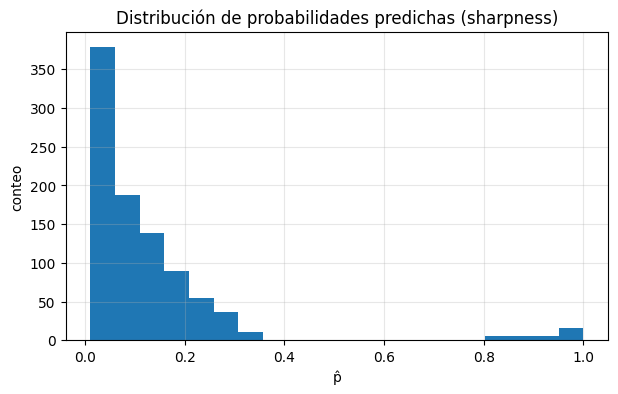

In [29]:
p = np.asarray(p_hat).ravel().astype("float32")
sharpness = float(np.var(p))     # varianza de las probabilidades predichas
spread    = float(np.std(p))     # desviación estándar (solo informativa)
print(f"Sharpness (var p̂) = {sharpness:.6f}   |   std(p̂) = {spread:.6f}")
print(f"min/mean/max p̂ = {p.min():.6f} / {p.mean():.6f} / {p.max():.6f}")

# (Opcional) histograma sin estilos fijos
plt.figure(figsize=(7,4))
plt.hist(p, bins=20)
plt.xlabel("p̂"); plt.ylabel("conteo")
plt.title("Distribución de probabilidades predichas (sharpness)")
plt.grid(True, alpha=0.3); plt.show()


In [ ]:
# --- 1. Asegúrate de usar el mejor modelo ---
model = tf.keras.models.load_model("modelo_prefijo_FINAL.keras")

# --- 2. Predicciones sobre todo el dataset ---
df_eval = df_prefix.copy()
df_eval["y_hat"] = model.predict(df_prefix[X_cols].to_numpy(dtype="float32"), verbose=0).ravel()

# --- 3. Tomar el último B2 (Bmax) por configuración ---
cfg_eval = (
    df_eval.sort_values(["group_id","B2"])
           .groupby("group_id", as_index=False)
           .tail(1)[["group_id","y_prefix","y_hat"]]
           .rename(columns={"y_prefix":"p_true","y_hat":"p_pred"})
)

# --- 4. Métricas ---
err  = cfg_eval["p_pred"] - cfg_eval["p_true"]
mae  = np.mean(np.abs(err))
rmse = np.sqrt(np.mean(err**2))
r2   = 1 - np.var(err)/np.var(cfg_eval["p_true"])

print("\n=== Métricas por configuración ===")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

# --- 5. (Opcional) muestra top-5 configuraciones con mayor error ---
cfg_eval["abs_err"] = np.abs(err)
print("\nTop 5 con mayor error:")
print(cfg_eval.sort_values("abs_err", ascending=False).head())


=== Métricas por configuración ===
MAE  = 0.0277
RMSE = 0.0616
R²   = 0.8277

Top 5 con mayor error:
                            group_id    p_true    p_pred   abs_err
3895  W256_w4_mu32_eta2_a0.001_b0.03  0.335143  1.000000  0.664857
2367  W192_w4_mu32_eta2_a0.001_b0.03  0.465104  1.000000  0.534896
4591  W256_w4_mu64_eta2_a0.001_b0.05  0.795062  1.000000  0.204938
2791   W192_w4_mu64_eta2_a0.001_b0.1  0.605081  0.795239  0.190158
4559  W256_w4_mu64_eta2_a0.001_b0.03  0.815060  1.000000  0.184940


In [40]:
print(cfg_eval.sort_values("abs_err", ascending=False).head(50))

                             group_id    p_true    p_pred   abs_err
3895   W256_w4_mu32_eta2_a0.001_b0.03  0.335143  1.000000  0.664857
2367   W192_w4_mu32_eta2_a0.001_b0.03  0.465104  1.000000  0.534896
4591   W256_w4_mu64_eta2_a0.001_b0.05  0.795062  1.000000  0.204938
2791    W192_w4_mu64_eta2_a0.001_b0.1  0.605081  0.795239  0.190158
4559   W256_w4_mu64_eta2_a0.001_b0.03  0.815060  1.000000  0.184940
1255    W128_w4_mu64_eta2_a0.001_b0.1  0.795062  0.977639  0.182577
4431    W256_w4_mu64_eta2_a0.001_b0.1  0.525093  0.364476  0.160616
2951   W192_w4_mu64_eta2_a0.001_b0.05  0.845058  1.000000  0.154942
3927   W256_w4_mu32_eta2_a0.001_b0.05  0.105417  0.248974  0.143557
3375   W256_w4_mu16_eta2_a0.001_b0.03  0.145312  0.009204  0.136108
423    W128_w4_mu2_eta32_a0.001_b0.03  0.155294  0.019603  0.135691
743    W128_w4_mu32_eta2_a0.001_b0.03  0.625078  0.493169  0.131909
1183  W128_w16_mu64_eta2_a0.001_b0.03  0.315152  0.198904  0.116247
2919   W192_w4_mu64_eta2_a0.001_b0.03  0.885056 

In [31]:
def predict_config_prefix_bins(model, df_prefix, GID, X_cols, eps=1e-6, verbose=True):
    # 1) Filtrar y ordenar por B2 (prefijos crecientes)
    rows = df_prefix.loc[df_prefix["group_id"] == GID].copy()
    if rows.empty:
        raise ValueError(f"GID no existe en df_prefix: {GID}")
    rows = rows.sort_values("B2").reset_index(drop=True)

    # 2) Matriz de features (mismo orden que en el entrenamiento)
    X_cfg = rows[X_cols].to_numpy(dtype="float32")

    # 3) Predicción de prefijos P(score ∈ [Bmin, B2))
    p_hat_prefix = model.predict(X_cfg, verbose=0).ravel()
    # (opcional) asegurar que sea monótona no-decreciente por numérica
    p_hat_prefix = np.maximum.accumulate(p_hat_prefix)
    p_hat_prefix = np.clip(p_hat_prefix, 0.0, 1.0)

    # 4) Probabilidad por bin puro = diferencia de prefijos consecutivos
    p_hat_bin = np.diff(np.concatenate(([0.0], p_hat_prefix)))
    p_hat_bin = np.clip(p_hat_bin, 0.0, 1.0)  # evita redondeos negativos/ >1
    # puede rehacer para que sumen exactamente al último prefijo:
    total = p_hat_prefix[-1]
    s = p_hat_bin.sum()
    if s > 0:
        p_hat_bin *= (total / s)

    # 5) (opcional) comparar contra etiquetas empíricas si están en df_prefix
    has_true = "y_prefix" in rows.columns
    p_true_prefix = rows["y_prefix"].to_numpy(dtype="float32") if has_true else None
    p_true_bin = None
    if has_true:
        p_true_prefix = np.clip(p_true_prefix, 0.0, 1.0)
        p_true_prefix = np.maximum.accumulate(p_true_prefix)  # por si acaso
        p_true_bin = np.diff(np.concatenate(([0.0], p_true_prefix)))

    if verbose:
        print("GID:", GID)
        print("B2 cortes:", rows["B2"].tolist())
        print("P_hat prefix:", p_hat_prefix.tolist())
        print("P_hat por bin:", p_hat_bin.tolist())
        print("P_global_hat:", float(p_hat_prefix[-1]))
        if has_true:
            mae_pref = float(np.mean(np.abs(p_hat_prefix - p_true_prefix)))
            mae_bin  = float(np.mean(np.abs(p_hat_bin - p_true_bin)))
            print(f"MAE prefix={mae_pref:.4f}  MAE bin={mae_bin:.4f}")

    return {
        "GID": GID,
        "B2_list": rows["B2"].to_numpy(),
        "p_hat_prefix": p_hat_prefix,
        "p_hat_bin": p_hat_bin,
        "p_global_hat": float(p_hat_prefix[-1]),
        "p_true_prefix": p_true_prefix,
        "p_true_bin": p_true_bin,
    }


In [32]:
# 1) cargar el mejor modelo
model = tf.keras.models.load_model("modelo_prefijo_FINAL.keras")

# 2) elegir un GID existente
GID = df_prefix["group_id"].iloc[0]  # o cualquier otro que quieras

# 3) columnas de entrada (mismo orden que entrenaste)
X_cols = ["W","w","mu","eta","alpha","beta","Bmin","B2"]

# 4) correr la prueba
out = predict_config_prefix_bins(model, df_prefix, GID, X_cols, verbose=True)

# Acceso a los resultados programáticamente:
p_hat_prefix = out["p_hat_prefix"]
p_hat_bin    = out["p_hat_bin"]
p_global     = out["p_global_hat"]

GID: W128_w16_mu16_eta2_a0.001_b0.1
B2 cortes: [85727.0, 108743.0, 131759.0, 154775.0, 177791.0, 200807.0, 223822.0, 246837.0]
P_hat prefix: [0.020691299811005592, 0.020761631429195404, 0.020832180976867676, 0.02090626023709774, 0.0209821667522192, 0.021085182204842567, 0.021085182204842567, 0.021085182204842567]
P_hat por bin: [0.020691299811005592, 7.03316181898117e-05, 7.054954767227173e-05, 7.407926023006439e-05, 7.590651512145996e-05, 0.00010301545262336731, 0.0, 0.0]
P_global_hat: 0.021085182204842567
MAE prefix=0.0147  MAE bin=0.0029


In [33]:
# Config del modelo ganador (base)
base_cfg = dict(
    tag="deep_128x4_h005",
    hidden_layers=(128,128,128,128),
    loss="huber",
    huber_delta=0.05,
    dropout=0.20,
    use_batchnorm=False,
    lr=1e-3,
    l2=0.0
)

# Variantes para comparar (más neuronas / más capas)
wide_256x4 = dict(
    tag="deep_256x4_h005",
    hidden_layers=(256,256,256,256),
    loss="huber",
    huber_delta=0.05,
    dropout=0.30,          # ↑ dropout al ensanchar
    use_batchnorm=False,
    lr=5e-4,               # ↓ LR para redes más grandes
    l2=1e-5                # un toque de L2 ayuda a calibración
)

deep_128x6 = dict(
    tag="deep_128x6_h005",
    hidden_layers=(128,128,128,128,128,128),
    loss="huber",
    huber_delta=0.05,
    dropout=0.30,
    use_batchnorm=True,    # BN ayuda al hacerla más profunda
    lr=5e-4,
    l2=1e-5
)

huge_256x6 = dict(
    tag="deep_256x6_h005",
    hidden_layers=(256,256,256,256,256,256),
    loss="huber",
    huber_delta=0.05,
    dropout=0.35,
    use_batchnorm=True,
    lr=3e-4,
    l2=3e-5
)

arch_space = [base_cfg, wide_256x4, deep_128x6, huge_256x6]
df_cmp, best_model, best_path = run_and_rank(
    Xtr, ytr, Xte, yte,
    arch_space=arch_space,
    out_dir="exp_compare_deep128x4",
    max_epochs=300, batch_size=1024,
    seed=42, verbose=True
)
print(df_cmp.head(10)[["tag","val_min","test_brier","test_nll","model_path"]])


=== [1/4] deep_128x4_h005 ===
val_min=0.0008  test_brier=0.0019  test_nll=0.2824
→ checkpoint: exp_compare_deep128x4\best_deep_128x4_h005.keras
→ history:    exp_compare_deep128x4\deep_128x4_h005_history.csv

=== [2/4] deep_256x4_h005 ===
val_min=0.0010  test_brier=0.0026  test_nll=0.2896
→ checkpoint: exp_compare_deep128x4\best_deep_256x4_h005.keras
→ history:    exp_compare_deep128x4\deep_256x4_h005_history.csv

=== [3/4] deep_128x6_h005 ===
val_min=0.0010  test_brier=0.0029  test_nll=0.4082
→ checkpoint: exp_compare_deep128x4\best_deep_128x6_h005.keras
→ history:    exp_compare_deep128x4\deep_128x6_h005_history.csv

=== [4/4] deep_256x6_h005 ===
val_min=0.0026  test_brier=0.0212  test_nll=0.3358
→ checkpoint: exp_compare_deep128x4\best_deep_256x6_h005.keras
→ history:    exp_compare_deep128x4\deep_256x6_h005_history.csv

=== TOP 5 ===
               tag   val_min  test_brier  test_nll  \
0  deep_128x4_h005  0.000781    0.001862  0.282417   
1  deep_128x6_h005  0.001019    0.002860 

Tag detectado: deep_256x4_h005
Historial esperado: exp_compare_deep128x4\deep_256x4_h005_history.csv


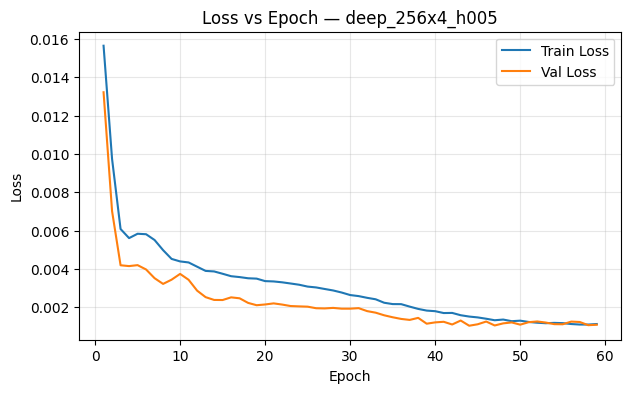

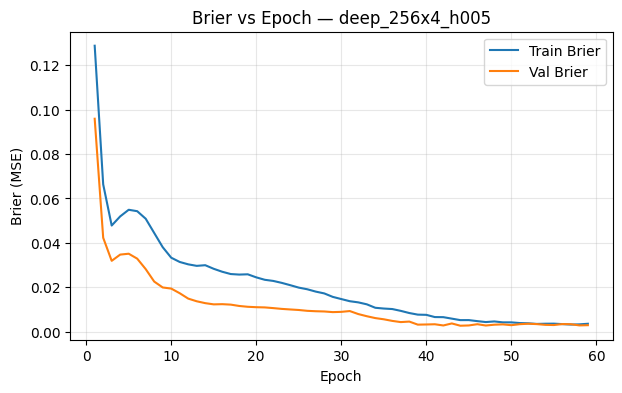

Predicciones test → min/mean/max: 0.002159 / 0.138539 / 0.891157
Brier_ext=0.0026  NLL_ext=0.2896


In [34]:
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

best_path = Path("exp_compare_deep128x4/best_deep_256x4_h005.keras")  # ← nuevo modelo
best_model = tf.keras.models.load_model(best_path)
best_model.save("modelo_compare.keras")  # opcional

tag = best_path.stem.replace("best_", "")
hist_csv = best_path.parent / f"{tag}_history.csv"
print("Tag detectado:", tag)
print("Historial esperado:", hist_csv)

if hist_csv.exists():
    hist = pd.read_csv(hist_csv)
    # Loss
    plt.figure(figsize=(7,4))
    plt.plot(hist["epoch"], hist["loss"], label="Train Loss")
    plt.plot(hist["epoch"], hist["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"Loss vs Epoch — {tag}")
    plt.legend(); plt.grid(True, alpha=0.3); plt.show()
    # Brier
    if "brier" in hist.columns and "val_brier" in hist.columns:
        plt.figure(figsize=(7,4))
        plt.plot(hist["epoch"], hist["brier"], label="Train Brier")
        plt.plot(hist["epoch"], hist["val_brier"], label="Val Brier")
        plt.xlabel("Epoch"); plt.ylabel("Brier (MSE)"); plt.title(f"Brier vs Epoch — {tag}")
        plt.legend(); plt.grid(True, alpha=0.3); plt.show()
else:
    print(f"⚠️ No se encontró el historial: {hist_csv}")

# Métricas en test
p_te = best_model.predict(Xte, verbose=0).ravel()
p_te = np.clip(p_te, 1e-6, 1-1e-6)
y_true = np.asarray(yte).ravel().astype("float32")
from sklearn.metrics import mean_squared_error
brier = mean_squared_error(y_true, p_te)
nll = float(tf.keras.losses.BinaryCrossentropy()(y_true, p_te).numpy())
print(f"Predicciones test → min/mean/max: {p_te.min():.6f} / {p_te.mean():.6f} / {p_te.max():.6f}")
print(f"Brier_ext={brier:.4f}  NLL_ext={nll:.4f}")


In [35]:
import tensorflow as tf, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error

candidatos = [
    "exp_ranked_models/best_deep_128x4_h005.keras",      # base (ganador anterior)
    "exp_compare_deep128x4/best_deep_256x4_h005.keras",  # nuevo ensanchado
]

def eval_model(path):
    m = tf.keras.models.load_model(path)
    p = m.predict(Xte, verbose=0).ravel()
    p = np.clip(p, 1e-6, 1-1e-6)
    brier = mean_squared_error(yte, p)
    nll = float(tf.keras.losses.BinaryCrossentropy()(yte, p).numpy())
    return dict(model_path=path, brier=brier, nll=nll, p_mean=float(p.mean()))

rows = [eval_model(p) for p in candidatos]
print(pd.DataFrame(rows).sort_values(["brier","nll"]))


                                         model_path     brier       nll  \
1  exp_compare_deep128x4/best_deep_256x4_h005.keras  0.002649  0.289635   
0      exp_ranked_models/best_deep_128x4_h005.keras  0.007695  0.395346   

     p_mean  
1  0.138539  
0  0.137492  


In [36]:
# --- 4) (Opcional) Métricas rápidas en test ---
p_te = best_model.predict(Xte, verbose=0).ravel()
p_te = np.clip(p_te, 1e-6, 1-1e-6)
y_true = np.asarray(yte).ravel().astype("float32")

from sklearn.metrics import mean_squared_error
brier = mean_squared_error(y_true, p_te)
import tensorflow as tf
nll = float(tf.keras.losses.BinaryCrossentropy()(y_true, p_te).numpy())

print(f"Predicciones test → min/mean/max: {p_te.min():.6f} / {p_te.mean():.6f} / {p_te.max():.6f}")
print(f"Brier_ext={brier:.4f}  NLL_ext={nll:.4f}")

Predicciones test → min/mean/max: 0.002159 / 0.138539 / 0.891157
Brier_ext=0.0026  NLL_ext=0.2896
